# [Suggestsongs.com](https://suggestsongs.com/)

Suggestsongs.com is a platform that aims to harmonize your musical tastes and amplify your playlists.

The primary objective of Suggestsongs.com is to help users discover new music that aligns with their preferences. Users can sign in with their Spotify accounts, allowing the tool to access their listening history, favorite songs, and playlists.

## Background
We created an app in which we generate song recommendations for the users of the app. This way the users can come across new songs to add to their playlists on Spotify.
The recommendations are based upon scores they gave to their own songs from their own playlist so our model can look for songs with the same features so the model makes valid recommendations.

We made a KNN model to try and predict the score that people with give to certain songs. We have done this with all scores and not on a personal basis.
This model had a accuracy of 30%. Our analysis of this is that every person has a different taste in music so predicting people's ratings based on the ratings of all people in the dataset
is pretty much undoable. 

## The data we collect
We collect some data to make recommendations for the user. We also collect some data to find out how our app is performing. Here are some datapoints:
1. User Info: User Id, Display name, email, product type, country, profile picture, login dates, auth keys to allow api request
2. User Track Rating: Track id, User Id, Rating, Date
3. Tracks: Track Id, Artist, Album, lots of audio features

The audio features will be used to find similar tracks for the user. The features are shown below in the code

## The Code

### Step 1: Loading the data using pandas

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

data = pd.read_csv('ratings.csv')
data.head()

,track_id,danceability,energy,key_,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,artist,album,duration_ms.1,popularity,explicit,url,track_id.1,user_id,rating,date
0,01KurZH1ejoarO8tp3wXGo,0.495,0.731,5,-8.320,1,0.0276,0.005120,0.0471,0.0979,...,Franz Ferdinand,Franz Ferdinand,259773.0,44,0,https://open.spotify.com/track/01KurZH1ejoarO8...,01KurZH1ejoarO8tp3wXGo,31uqhjwtpiiaay5ripzqwrdjw7ga,2.0,2024-03-12 20:27:08
1,01tykAEjuZsAX5I1y0FLf8,0.382,0.855,9,-8.068,1,0.0380,0.000147,0.7450,0.1060,...,Avatar,Construction of Souls,292735.0,40,0,https://open.spotify.com/track/01tykAEjuZsAX5I...,01tykAEjuZsAX5I1y0FLf8,31sk54n54vp7yoro5vkuuhi66gx4,5.0,2024-03-12 20:27:08
2,02tKPhHyLttuqmBEUTlmw2,0.237,0.783,0,-6.806,1,0.0284,0.002170,0.5690,0.4890,...,Youth Lagoon,Wondrous Bughouse,232266.0,22,0,https://open.spotify.com/track/02tKPhHyLttuqmB...,02tKPhHyLttuqmBEUTlmw2,31uqhjwtpiiaay5ripzqwrdjw7ga,6.0,2024-03-12 20:27:08
3,03GBiorLGTk7T4IScIl4jj,0.703,0.443,0,-9.601,0,0.0862,0.049900,0.0000,0.3380,...,SIX,Six: The Musical (Studio Cast Recording),350218.0,67,0,https://open.spotify.com/track/03GBiorLGTk7T4I...,03GBiorLGTk7T4IScIl4jj,yanniquevanmegen,10.0,2024-03-12 20:27:08
4,03HZaJepBONLxbgWTsV7AK,0.479,0.187,8,-15.742,1,0.0343,0.907000,0.8710,0.1380,...,The Bob Davis Group,Easy Living,203500.0,45,0,https://open.spotify.com/track/03HZaJepBONLxbg...,03HZaJepBONLxbgWTsV7AK,1166187914,6.0,2024-03-12 20:27:08


### Step 2: Dropping unnecessary columns which won't affect the rating of a song and counting the missing values

In [2]:
columns_to_drop = ['track_id', 'artist', 'album', 'url', 'track_id.1', 'date', 'user_id', 'id', 'name', 'duration_ms']
data_useful = data.drop(columns=columns_to_drop)
missing_values = data_useful.isnull().sum()

### Step 3: Cleaning up the missing values in the rating column. Those aren't usable for the model.

In [3]:
data4 = data_useful.dropna(subset=['rating'])
data4.head()

,danceability,energy,key_,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms.1,popularity,explicit,rating
0,0.495,0.731,5,-8.320,1,0.0276,0.005120,0.0471,0.0979,0.384,125.568,4,259773.0,44,0,2.0
1,0.382,0.855,9,-8.068,1,0.0380,0.000147,0.7450,0.1060,0.550,136.138,4,292735.0,40,0,5.0
2,0.237,0.783,0,-6.806,1,0.0284,0.002170,0.5690,0.4890,0.565,170.768,3,232266.0,22,0,6.0
3,0.703,0.443,0,-9.601,0,0.0862,0.049900,0.0000,0.3380,0.367,136.647,4,350218.0,67,0,10.0
4,0.479,0.187,8,-15.742,1,0.0343,0.907000,0.8710,0.1380,0.156,119.415,4,203500.0,45,0,6.0


### Step 4: Show the missing values

In [4]:
data4.isnull().sum()

danceability         0
energy               0
key_                 0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
duration_ms.1       11
popularity           0
explicit             0
rating               0
dtype: int64

### Step 5: Simple regression model to check if the duration of the song has a significant enough impact on the rating. 

In [5]:
model1 = smf.ols('rating ~ Q("duration_ms.1")', data=data4).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     22.38
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           2.74e-06
Time:                        11:56:11   Log-Likelihood:                -1325.2
No. Observations:                 650   AIC:                             2654.
Df Residuals:                     648   BIC:                             2663.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.8279      0.251     23.180      0.000       5.334       6.322
Q("duration_ms.1")  4.959e-06   1.05e-06      4.731      0.000     2.9e-06    7.02e-06
==============================================================================
Omnibus:                       35.050   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.924
Skew:                          -0.554   Prob(JB):                     2.14e-09
Kurtosis:                       3.496   Cond. No.                     8.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Step 6: Drop duration
Because we give little snippets of songs to rate, the entire duration is not of any value to the rating. Thus we drop it from the data.

In [6]:
data_cleaned = data4.drop(columns=['duration_ms.1'])
data_cleaned.head()

,danceability,energy,key_,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,explicit,rating
0,0.495,0.731,5,-8.320,1,0.0276,0.005120,0.0471,0.0979,0.384,125.568,4,44,0,2.0
1,0.382,0.855,9,-8.068,1,0.0380,0.000147,0.7450,0.1060,0.550,136.138,4,40,0,5.0
2,0.237,0.783,0,-6.806,1,0.0284,0.002170,0.5690,0.4890,0.565,170.768,3,22,0,6.0
3,0.703,0.443,0,-9.601,0,0.0862,0.049900,0.0000,0.3380,0.367,136.647,4,67,0,10.0
4,0.479,0.187,8,-15.742,1,0.0343,0.907000,0.8710,0.1380,0.156,119.415,4,45,0,6.0


### Step 7: Splitting data into train and test
Splitting the dataset into features (X) and target (y). Splitting into training and testing sets

In [7]:
X = data_cleaned.drop('rating', axis=1)
y = data_cleaned['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((528, 14), (133, 14))

### Step 8: KNN Model
#### Step 8.1: Training the KNN Model

In [8]:
# Define a list of possible values for N
n_values = list(range(3, 101, 2))

# Create an empty list to store the cross-validation scores
cv_scores = []

# Iterate over each value of N
for n in n_values:
    # Create a new KNN model with the current value of N
    knn = KNeighborsClassifier(n_neighbors=n)
    
    # Perform cross-validation and calculate the mean accuracy score
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    mean_score = scores.mean()
    
    # Append the mean score to the list of scores
    cv_scores.append(mean_score)

# Find the index of the best score
best_index = cv_scores.index(max(cv_scores))

# Get the best value of N
best_n = n_values[best_index]

# Print the best value of N
print("The best value of N is:", best_n)
knn = KNeighborsClassifier(n_neighbors=best_n)
knn.fit(X_train, y_train)


The best value of N is: 41


KNeighborsClassifier(n_neighbors=41)

#### Step 8.2: Predicting and Evaluating the Model
Predict the responses for the test dataset

Accuracy: 0.3007518796992481


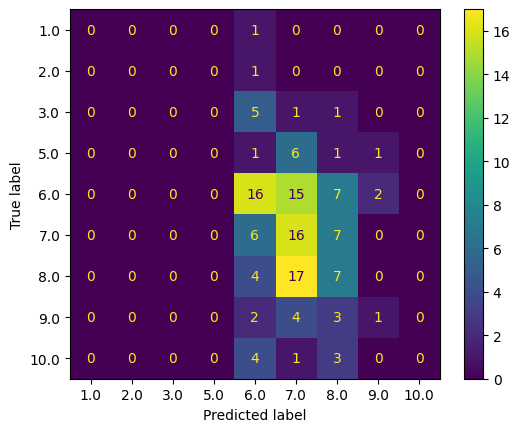

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         7
         5.0       0.00      0.00      0.00         9
         6.0       0.40      0.40      0.40        40
         7.0       0.27      0.55      0.36        29
         8.0       0.24      0.25      0.25        28
         9.0       0.25      0.10      0.14        10
        10.0       0.00      0.00      0.00         8

    accuracy                           0.30       133
   macro avg       0.13      0.14      0.13       133
weighted avg       0.25      0.30      0.26       133



C:\Users\Larsc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Larsc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Larsc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [9]:
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
unique_classes = np.unique(np.concatenate((y_test, y_pred)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred))


## (short) Discussion

Currently we have a KNN model for everyone, all at once. But it might be more useful to make one KNN model for every single user of the app. The baseline might be a standard KNN based on all users that can be tweaked with the preferences of one specific user.

For business value it might be valuable to look into user logins and session durations. Our goal is to give better songs that might fit their taste, so one of our KPI's might be to see if the average rating increases. _We have the rating and login data, not the session durations. If we are able to push our app to production (with spotify accepting our usecase) we will be able to get more users._